In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ml/Poetry

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ml/Poetry


In [ ]:
import csv

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

In [ ]:
# Load Data
titles = []
poems = []

with open('PoetryFoundationData.csv', encoding='utf8') as data_raw:
	data_csv = csv.reader(data_raw)
	for row in data_csv:
		if (row[0] == ''): # Skip empty rows
			continue
		poem = row[2]
		poems.append(poem)

In [ ]:
# Clean Data
poems_data = poems[:600]

# Tokenize Data
tokenizer = Tokenizer(oov_token="<OOV>", filters='')
tokenizer.fit_on_texts(poems_data) # Create dictionary

total_words = len(tokenizer.word_index) + 1

# Sequence Data (Only use for small datasets)
sequence_data = []
for poem in poems_data:
	sequence = tokenizer.texts_to_sequences([poem])[0] # Convert to sequence
	for i in range(1, min(len(sequence), 80)): # Create pairs out of sequence
		n_gram_sequence = sequence[:i+1]
		sequence_data.append(n_gram_sequence)

# Pad Data
max_length = max(len(x) for x in sequence_data)
sequence_data = pad_sequences(sequence_data, maxlen=max_length, padding='pre')

In [ ]:
# Save Tokens
open("tokens_v4.json", "w").write(tokenizer.to_json())

max_length

80

In [ ]:
# Split Data
data, labels = sequence_data[:,:-1], sequence_data[:,-1] # Split into data and labels
labels = ku.to_categorical(labels, num_classes=total_words) # Convert to one-hot encoding

In [ ]:
model = load_model('ai_poet_v3.h5')

In [ ]:
# Build Model
model = Sequential()
model.add(Embedding(total_words, 80, input_length=max_length-1))
model.add(Bidirectional(LSTM(120, return_sequences=True)))
model.add(Dropout(0.1))
model.add(LSTM(80))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train Model
history = model.fit(data, labels, epochs=5, batch_size=64, verbose=1)

Epoch 1/5
703/703 [==============================] - 400s 559ms/step - loss: 8.6421 - accuracy: 0.0576
Epoch 2/5
703/703 [==============================] - 392s 558ms/step - loss: 7.7790 - accuracy: 0.0586
Epoch 3/5
703/703 [==============================] - 392s 558ms/step - loss: 7.4933 - accuracy: 0.0659
Epoch 4/5
703/703 [==============================] - 389s 554ms/step - loss: 7.2835 - accuracy: 0.0693
Epoch 5/5
703/703 [==============================] - 397s 564ms/step - loss: 7.0353 - accuracy: 0.0802


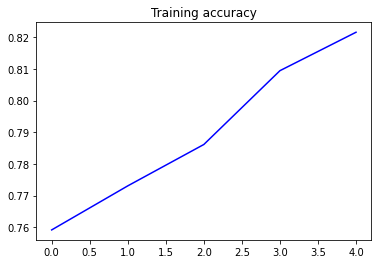

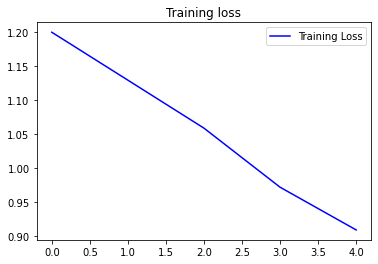

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
# Predict Outcome
message = 'the rose'
size = 25

for _ in range(size):
	sequence = tokenizer.texts_to_sequences([message])[0]
	sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')
	prediction = np.argmax(model.predict(sequence), axis=1)
	index = prediction[0]
	message += ' ' + tokenizer.index_word[index]

In [ ]:
message

'the tree of lobsters;i am likewise at peace in my little cottagetrying to become mr. five willows. i figure a crabapple is useful to a pencil—its long,'

In [ ]:
model.save("ai_poet_v3_3.h5", save_format="h5")